In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Read Data**

In [2]:
df = pd.read_csv('Simulated_Cashflow_Lit.txt',sep=';')
df.head()

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,...,Lit05,Lit06,Lit07,Lit08,Lit09,Lit10,Lit11,lit_year_relative,k_year,UC
0,1.0,1.0,46.0,1.0,1.0,32.0,42.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,0.0
1,2.0,1.0,43.0,1.0,1.0,15.0,18.0,0.0,651.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,651.0
2,3.0,2.0,47.0,1.0,0.0,39.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,0.0
3,4.0,1.0,38.0,1.0,2.0,36.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,0.0
4,5.0,2.0,18.0,1.0,0.0,59.0,31.0,0.0,4455.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,4455.0


In [3]:
EXPORT_NAME = "temp"

pickle_path = 'deep_pickles/' + EXPORT_NAME
RNN_df = pd.read_pickle(pickle_path)

In [4]:
RNN_df

,AY,RepDel,UC,Estimated_UC
0,2.0,0.0,0.0,0.000000
1,2.0,0.0,1790.1,1790.099907
2,2.0,0.0,911.0,910.999966
3,2.0,0.0,0.0,0.000000
4,2.0,0.0,619.3,619.300003
...,...,...,...,...
413563,12.0,0.0,177.0,177.000000
413564,12.0,0.0,578.0,578.000000
413565,12.0,0.0,3353.0,3353.000000
413566,12.0,0.0,1580.0,1580.000000


In [5]:
!pip install import_ipynb

In [6]:
import import_ipynb
import ChainLadder
import tools
CL = ChainLadder.chain_ladder(df)
CL_UC = CL.chain_ladder_average_UC()

importing Jupyter notebook from ChainLadder.ipynb
importing Jupyter notebook from tools.ipynb


**Functions**

In [7]:
def get_average_UC(rep_del,df):
    min_AY = df.AY.min()
    n_years = 12-rep_del
    df_new = df[(df['RepDel']==rep_del)]
    
    avg_uc = np.zeros(n_years)
    for i in range(n_years):
        avg_uc[i] = df_new[(df_new['AY']==min_AY+i)].UC.mean()
    return avg_uc

In [8]:
def get_average_UC_RNN(rep_del,df):
    min_AY = df.AY.min()
    n_years = 12-rep_del
    df_new = df[(df['RepDel']==rep_del)]
    
    avg_uc = np.zeros(n_years)
    for i in range(1,n_years):
        avg_uc[i] = df_new[(df_new['AY']==min_AY+i)].RNN_prediction.mean()
    return avg_uc

**Plot average ultimate cost with respect to AY and RepDel**

In [9]:
list(range(1994,2006))

[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005]

Text(0, 0.5, 'Ultimate cost')

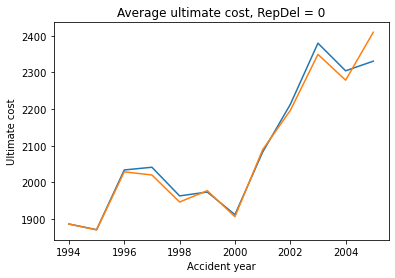

In [10]:
rep_del = 0
AY = list(range(1994,2006-rep_del))
plt.plot(AY,get_average_UC(rep_del,df))
plt.plot(AY,CL_UC.loc[CL_UC['RepDel'] == rep_del].avg_UC.reset_index(drop = True))
#plt.plot(get_average_UC_RNN(rep_del,RNN_df))
title = 'Average ultimate cost, RepDel = ' + str(rep_del)
plt.title(title)
plt.xlabel('Accident year')
plt.ylabel('Ultimate cost')

**Total Reserves**

In [3]:
test_df = df[df['k_year'] != 11]
total_cost = test_df.UC.sum()
total_paid = 0
column_indices = {c: i for i, c in enumerate(df.columns)}
pay00i = column_indices['Pay00']
test_df_arr = np.array(test_df)
for i in range(len(test_df)):
    if test_df_arr[i,column_indices['UC']] != 0:
        k = int(test_df_arr[i,column_indices['k_year']])
        
        total_paid += np.sum(test_df_arr[i,pay00i:(pay00i + 1 + k)])

ACTUAL = total_cost - total_paid
print("Total paid: ", total_paid)
print("ACTUAL RESERVE: ", ACTUAL)


Total paid:  823081109.0499977
ACTUAL RESERVE:  120408600.45000255


In [12]:
baseline_df = tools.no_reserve(test_df,column_indices['k_year'],pay00i)
baseline_RMSE = np.sqrt(((baseline_df.UC - baseline_df.Estimated_UC)**2).mean())
baseline_total_cost = baseline_df.Estimated_UC.sum()
baseline_reserve = round(baseline_total_cost - total_paid)
print("BASELINE RESERVE: ", baseline_reserve)
print("error percentage: ", (baseline_reserve-ACTUAL)/ACTUAL*100)
print("BASELINE RMSE: ", baseline_RMSE)

BASELINE RESERVE:  0.0
error percentage:  -100.0
BASELINE RMSE:  6343.606859371897


<string>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
CL_test = CL_UC.loc[CL_UC['AY'] != 1]
CL_total_cost = np.sum(CL_test.avg_UC * CL_test.Exposure)
CL_RESERVE = CL_total_cost - total_paid

print("CL_RESERVE: ",CL_RESERVE)
print("error percentage: ", (CL_RESERVE-ACTUAL)/ACTUAL*100)

CL_RESERVE:  120553607.61799765
error percentage:  0.12042924463299182


In [14]:
RNN_total_cost = RNN_df.Estimated_UC.sum()
RNN_RESERVE = RNN_total_cost - total_paid
RNN_RMSE = np.sqrt(((RNN_df.UC - RNN_df.Estimated_UC)**2).mean())
print("RNN_RESERVE: ",RNN_RESERVE)
print("error percentage: ", (RNN_RESERVE-ACTUAL)/ACTUAL*100)
print("RNN RMSE: ", RNN_RMSE)

RNN_RESERVE:  158196526.0240028
error percentage:  31.38307847842728
RNN RMSE:  9467.451261281049


In [15]:
RNN_total_cost

981277635.0740005

In [16]:
RNN_df.head(50)

,AY,RepDel,UC,Estimated_UC
0,2.0,0.0,0.00,0.000000
1,2.0,0.0,1790.10,1790.099907
2,2.0,0.0,911.00,910.999966
3,2.0,0.0,0.00,0.000000
4,2.0,0.0,619.30,619.300003
5,2.0,0.0,353.80,353.800001
6,2.0,1.0,77729.00,77729.003906
7,2.0,0.0,665.60,665.600014
8,2.0,1.0,1298.70,1298.700047
9,2.0,0.0,0.00,0.000000


In [17]:
total_paid

823081109.0499977